<a href="https://colab.research.google.com/github/truongnd2608/Genetic-Algorithm-KNN/blob/main/RAPIDS_Genetic_Algorithm_KNN_%5BCV_0_01840%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iterativestratification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F913213%2F1547693%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T152848Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D86541d65f337cd87b6fd4b2b750918ebfc1ca2fa20dcf7863b0780e4b140f3774503056108f8a20a2383e7b713498d1a29b08c92f1904a74ef96d9a069f87b6445950c1c0ed84fe7f0ac0582e83c9e715680589712de692deb47c087949b5c3d37262f6f6096be6923c0545c54a67451a9c1226f568d41eb7fe03cf4c51ab1f535b72e134b8577ed9cadfe7153fb311c3eea9f51966241c0b840176891e72e067cf432c565b4a96dc720a0b6c6c1500dc2c9a051ab4f99875441c6dc6c38bf85e243b9d4645fbe04972a367edbad6ab5ec1be5e6ec3fb192eb929886380f0f78aa1de3a9acaaba75dfe201543b2ba70300ea96f6c458159831c9ba84109cc601'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10430 bytes downloaded
Downloaded and uncompressed: iterativestratification
Data source import complete.


# RAPIDS - Genetic Algorithm KNN - [CV 0.01840]
The RAPIDS library is now available in all Kaggle notebooks. Hooray! Simply type `import cuml` or `import cudf` to load the two most popular packages.

RAPIDS is described [here][1]. RAPIDS `cuDF` accelerates dataframe operations using GPU and has a similar api as Pandas. RAPIDS `cuML` accelerates machine learning algorithms using GPU and has a similar api as Scikit-Learn. Since RAPIDS ML algorithms are so fast, we can do things that were never possible like applying genetic algorithms to ML hyperparameter searchs!

The ML algorithm kNN is very sensitive to the scaling of the feature columns. In this notebook, we find the weights for feature columns (`0 <= w <= 1`) using a genetic algorithm. This is similar to a feature selection algorithm like ridge regression which shrinks the importance of features. Alternatively we could mimic lasso regression if we choose only weights `w = 0` and `w = 1`.

[1]: https://rapids.ai/

In [19]:
# Get the latest RAPIDS version and install RAPIDS and cuML
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!python rapids-colab.sh
%cd ..

# Set environment variables
import os
os.environ['LD_LIBRARY_PATH'] = f'/usr/local/cuda/lib64:{os.environ.get("LD_LIBRARY_PATH", "")}'
os.environ['PATH'] = f'/usr/local/cuda/bin:{os.environ.get("PATH", "")}'

# Restart the runtime after installing RAPIDS and cuML
from IPython.display import clear_output
clear_output()


In [3]:
pip install iterative-stratification

In [5]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 707.3 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.2.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.7/464.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 617.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.6/917.6 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 12.5 MB/s eta 0:

In [6]:
import cuml
print("cuML version:", cuml.__version__)


cuML version: 24.02.00


# Load Libraries

In [20]:
import sys, warnings
warnings.filterwarnings("ignore")
sys.path.append('../input/iterativestratification')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.metrics import log_loss

import cuml
print('RAPIDS',cuml.__version__)

RAPIDS 24.02.00


# Load Data

In [26]:
train = pd.read_csv('lish-moa/train_features.csv')
print('train shape',train.shape)
test = pd.read_csv('lish-moa/test_features.csv')
print('test shape',test.shape)
targets = pd.read_csv('lish-moa/train_targets_scored.csv')

train shape (23814, 876)
test shape (3982, 876)


In [27]:
train.cp_dose = train.cp_dose.map({'D1':-1,'D2':1})
test.cp_dose = test.cp_dose.map({'D1':-1,'D2':1})

train.cp_time = train.cp_time.map({24:-1, 48:0, 72:1})
test.cp_time = test.cp_time.map({24:-1, 48:0, 72:1})

train.cp_type = train.cp_type.map({'trt_cp':-1, 'ctl_vehicle':1})
test.cp_type = test.cp_type.map({'trt_cp':-1, 'ctl_vehicle':1})

train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,-1,-1,-1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,-1,1,-1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,-1,0,-1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,-1,0,-1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,-1,1,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Double Stratified K Fold
We will use double stratified folds discussed [here][1]
  
[1]: https://www.kaggle.com/c/lish-moa/discussion/195195

In [28]:
def make_folds(folds = 5, random_state = 0, stratify = True, scored = None):

    drug = pd.read_csv('lish-moa/train_drug.csv')
    if scored is None:
        scored = pd.read_csv('lish-moa/train_targets_scored.csv')
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left')

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc<=18].index.sort_values()
    vc2 = vc.loc[vc>18].index.sort_values()

    # STRATIFY DRUGS 18 OR LESS
    dct1 = {}; dct2 = {}
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)

    # STRATIFY DRUGS MORE THAN 18
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)

    # ASSIGN FOLDS
    scored['fold'] = np.nan
    scored['fold'] = scored.drug_id.map(dct1)
    scored.loc[scored.fold.isna(),'fold'] = scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
    scored.fold = scored.fold.astype('int8')

    return scored[['sig_id','fold']].copy()

# Initialize Variables
Our genetic algorithm works as follows. Each generation, we take the best `sqrt(POPULATION)` sets of weights and then we randomly combine them in pairs to create a new population of size `POPULATION`. We also apply `MUTATE` percentage of mutations (i.e. randomly change some weights). We can think of a set of weights as "DNA".

In [29]:
GENERATIONS = 20
POPULATION = 100 # must be perfect square
PARENTS = int( np.sqrt(POPULATION) )
MUTATE = 0.05

# RANDOMLY CREATE CV
FOLDS = 5; SEED = 42
ff = make_folds(folds=FOLDS, random_state=SEED, stratify=True, scored=targets)
train['fold'] = ff.fold.values
targets['fold'] = ff.fold.values

# INITIALIZE
oof = np.zeros((len(train),206))
dna = np.random.uniform(0,1,(POPULATION,875))**2.0
cvs = np.zeros((POPULATION))

# Genetic Search

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

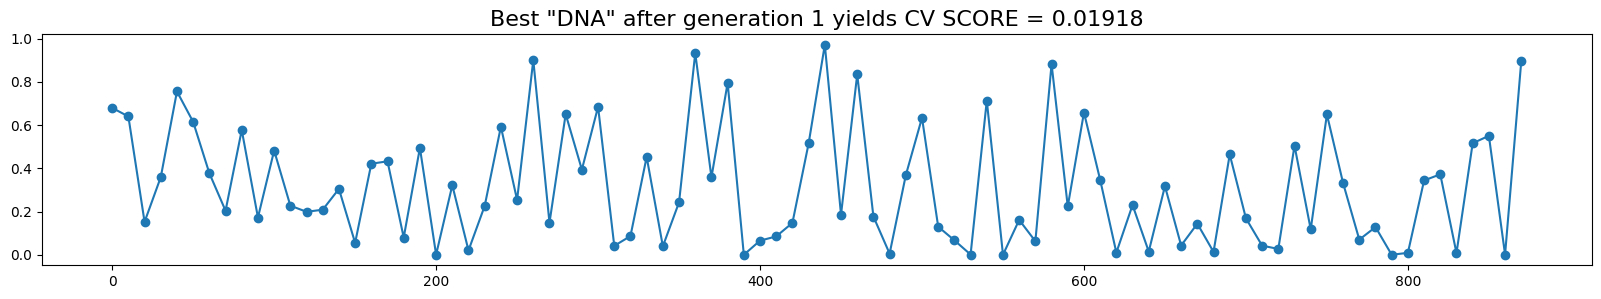

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 

In [ ]:
%%time
for jj in range(GENERATIONS):

    # ALL PREVIOUS POPULATION "DNA" AND CV SCORES
    df = pd.DataFrame(data=dna)
    df['cv'] = cvs
    df.sort_values('cv',inplace=True)
    print('Evolving...')

    # GENERATE AND EVALUATE CHILDREN
    for k in range(POPULATION):
        print(k,', ',end='')

        # GENERATE CHILD
        if jj!=0:
            parent1 = k//PARENTS; parent2 = k%PARENTS
            TMP = np.random.randint(0,2,875)
            dna[k,] = TMP * df.iloc[parent1,:-1] + (1-TMP) * df.iloc[parent2,:-1]
            x = np.random.uniform(0,1,875)
            IDX = np.where(x<MUTATE)[0]
            dna[k,IDX] = np.random.uniform(0,1,len(IDX))**2.0
        else:
            dna[k,] = df.iloc[k,:-1]

        # KNN WEIGHTS
        WGT = dna[k,]
        # WEIGHTS FOR CP_TYPE, CP_TIME, CP_DOSE
        WGT[0]= 100 ; WGT[1] = 12/2; WGT[2] = 5/2

        # KNN KFOLD VALIDATE
        for fold in range(FOLDS):
            model = cuml.neighbors.KNeighborsClassifier(n_neighbors=1000)
            model.fit( train.loc[ train.fold!=fold, train.columns[1:-1] ].values * WGT,
                       targets.loc[targets.fold!=fold, targets.columns[1:-1] ] )

            pp = model.predict_proba( train.loc[ train.fold==fold, train.columns[1:-1] ].values * WGT )
            pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
            oof[targets.fold==fold,] = pp

        cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
        cvs[k] = cv_score

    # DISPLAY BEST "DNA"
    RES = 10
    idx = np.argmin(cvs)
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(872)[::RES],dna[idx,3:][::RES],'o-')
    plt.title('Best "DNA" after generation %i yields CV SCORE = %.5f'%(jj+1,np.min(cvs)),size=16)
    plt.show()

# Show all population "DNA" with CV scores
Each row in the dataframe below is one set of weights from our evolved population. The first column indicates the cv score and the next 875 columns are the weights that we scale the 875 features with. (The weights can be thought of as "DNA" in the context of genetic algorithm). We will save the "DNA" to disk.

In [ ]:
df = pd.DataFrame(data=dna)
df['cv'] = cvs
df = df[['cv']+list(np.arange(0,875))]
df.sort_values('cv',inplace=True)
df.to_csv('dna.csv',index=False)
df.head()

# Predict Test Data

In [ ]:
WGT = df.iloc[0,1:].values
oof = np.zeros((len(train),206))
preds = np.zeros((len(test),206))

for fold in range(FOLDS):
    print('FOLD %i'%(fold+1), ' ', end='')

    model = cuml.neighbors.KNeighborsClassifier(n_neighbors=1000)
    model.fit( train.loc[ train.fold!=fold, train.columns[1:-1] ].values * WGT,
               targets.loc[targets.fold!=fold, targets.columns[1:-1] ] )

    pp = model.predict_proba( train.loc[ train.fold==fold, train.columns[1:-1] ].values * WGT )
    pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
    oof[targets.fold==fold,] = pp

    pp = model.predict_proba( test[test.columns[1:]].values * WGT )
    pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
    preds += pp/FOLDS

print()
cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
print('CV SCORE = %.5f'%cv_score)

# Clip and Submit
If we predict 0 when the true target is 1, we are severly penalized in this competition's metric. Therefore we clip our predictions and observe an increase of CV LB 0.00050! We will save the OOF to disk before clipping.

In [ ]:
df_oof = targets.copy()
df_oof.iloc[:,1:-1] = oof
df_oof.to_csv('oof.csv',index=False)

oof = np.clip(oof,0.0005,0.999)
oof[train.cp_type==1,] = 0

cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
print('CV SCORE with CLIPPING = %.5f'%cv_score)

In [ ]:
sub = pd.read_csv('lish-moa/sample_submission.csv')
sub.iloc[:,1:] = np.clip(preds,0.0005,0.999)
sub.loc[test.cp_type==1,sub.columns[1:]] = 0
sub.to_csv('submission.csv',index=False)
sub.head()

In [ ]:
targets.iloc[:,1:-1].mean()

In [ ]:
sub.iloc[:,1:].mean()